### 01. Import Dependecies

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


### 02. Load PCA features

In [2]:

data_path = '../data/PCA__components.csv'
#data_path = '../data/UMAP_components.csv'
df_pca = pd.read_csv(data_path)
df_pca.head()


,PC1,PC2,PC3,PC4,PC5,PC6
0,1.551478,-0.458427,0.756014,0.038581,0.024421,0.008358
1,1.604157,-0.211674,-0.429546,0.756912,-0.036418,0.097103
2,1.051584,-0.228823,-0.491327,-0.644556,0.046361,0.035951
3,-1.747707,0.854647,0.181268,0.050873,-0.082398,-0.052823
4,-1.323954,-0.193574,-0.414910,0.752750,-0.051228,-0.023053


### 03. Find optimal eps using k-distance graph

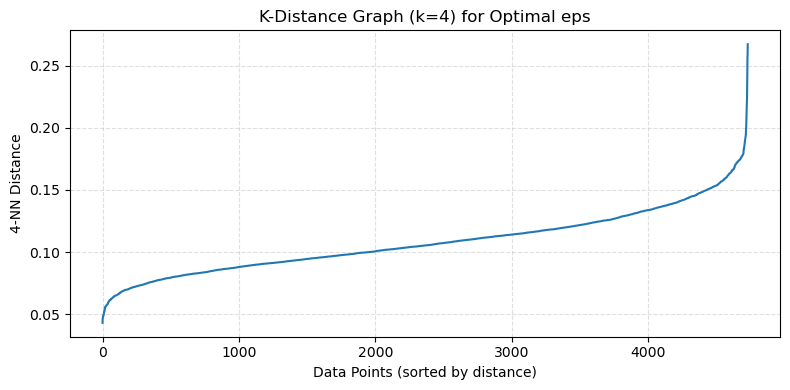

Suggested eps (90th percentile): 0.142


In [3]:

# Calculate distances to k-th nearest neighbor
k = 4  # min_samples parameter
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_pca)
distances, indices = neighbors_fit.kneighbors(df_pca)

# Sort distances to k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.xlabel('Data Points (sorted by distance)')
plt.ylabel(f'{k}-NN Distance')
plt.title(f'K-Distance Graph (k={k}) for Optimal eps')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Suggest eps (elbow point in the graph)
# You can visually inspect the graph or use percentile
suggested_eps = np.percentile(distances, 90)
print(f'Suggested eps (90th percentile): {suggested_eps:.3f}')


### 04. Tune eps and min_samples parameters

In [4]:

eps_values = np.linspace(0.1, suggested_eps * 2, 10)
min_samples_values = [3, 4, 5, 6]

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Calculate silhouette score (only if we have at least 2 clusters and not all noise)
        if n_clusters >= 2 and n_noise < len(df_pca) * 0.5:
            score = silhouette_score(df_pca, labels)
        else:
            score = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': score
        })
        
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

results_df = pd.DataFrame(results)
print('Top 5 parameter combinations:')
print(results_df.nlargest(5, 'silhouette_score')[['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette_score']])
print(f'\nBest parameters: eps={best_params["eps"]:.3f}, min_samples={best_params["min_samples"]}')


Top 5 parameter combinations:
         eps  min_samples  n_clusters  n_noise  silhouette_score
24  0.222331            3          16        0          0.124073
28  0.242719            3          16        0          0.124073
29  0.242719            4          16        0          0.124073
30  0.242719            5          16        0          0.124073
32  0.263107            3          16        0          0.124073

Best parameters: eps=0.222, min_samples=3


### 05. Fit DBSCAN with best parameters

In [5]:

dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
cluster_labels = dbscan.fit_predict(df_pca)

df_clusters = df_pca.copy()
df_clusters['cluster'] = cluster_labels

# Statistics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points (outliers): {n_noise} ({n_noise/len(df_pca)*100:.1f}%)')
print(f'\nCluster distribution:')
print(df_clusters['cluster'].value_counts().sort_index())


Number of clusters: 16
Number of noise points (outliers): 0 (0.0%)

Cluster distribution:
cluster
0     600
1     559
2     541
3     614
4     196
5     197
6     191
7     209
8     206
9     221
10    191
11    198
12    228
13    198
14    203
15    178
Name: count, dtype: int64


### 06. DBSCAN with better parameters


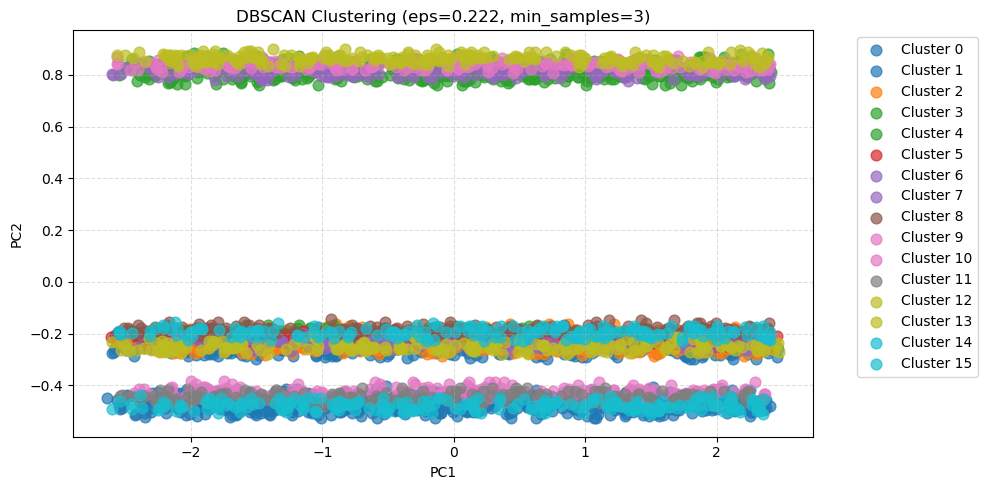

In [6]:

plt.figure(figsize=(10, 5))

# Plot clusters
unique_labels = set(cluster_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points (outliers) in black
        mask = cluster_labels == k
        plt.scatter(
            df_clusters.loc[mask, 'PC1'],
            df_clusters.loc[mask, 'PC2'],
            c='black',
            marker='x',
            s=50,
            alpha=0.6,
            label='Noise (Outliers)'
        )
    else:
        mask = cluster_labels == k
        plt.scatter(
            df_clusters.loc[mask, 'PC1'],
            df_clusters.loc[mask, 'PC2'],
            c=[col],
            s=60,
            alpha=0.7,
            label=f'Cluster {k}'
        )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'DBSCAN Clustering (eps={best_params["eps"]:.3f}, min_samples={best_params["min_samples"]})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
